# Data analysis

## Import all third-party libraries

In [81]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr, kendalltau
import copy

## Get data

In [51]:
DATA_DIR = 'data/'

with open(f"{DATA_DIR}train_hh.json") as f:
    hh_dialog = json.load(f)

with open(f"{DATA_DIR}train_hb.json") as f:
    hb_dialog = json.load(f)

## Helper functions

In [216]:
UTT_LEN_LIMIT = 40
NP_LEN_LIMIT = 15
NLL_LIMIT = 10**3

In [217]:
def calc_average_utt_len(dataset):
    avg_utts = []
    for d in dataset:
        utterances = 0
        utt_lengths = 0
        for th in d['thread']:
            if th['UTT_LEN'] <= UTT_LEN_LIMIT:
                utterances += 1
                utt_lengths += th['UTT_LEN']
        if utterances != 0 and utt_lengths / utterances <= 25:
            avg_utts.append(utt_lengths / utterances)
    return avg_utts

In [218]:
def calc_average_np_len(dataset):
    avg_nps = []
    for d in dataset:
        utterances = 0
        np_lengths = 0
        for th in d['thread']:
            if th['NP_LEN'] <= NP_LEN_LIMIT:
                utterances += 1
                np_lengths += th['NP_LEN']
        if utterances != 0:
            avg_nps.append(np_lengths / utterances)
    return avg_nps

In [219]:
def calc_average_nll(dataset):
    avg_nll = []
    for d in dataset:
        utterances = 0
        nlls = 0
        for th in d['thread']:
            if 'NLL' in th and th['NLL'] <= NLL_LIMIT:
                utterances += 1
                nlls += th['NLL']
        if utterances != 0:
            avg_nll.append(nlls / utterances)
    return avg_nll

In [220]:
def filter_users(dataset, kind):
    new_dataset = copy.deepcopy(dataset)
    for d in new_dataset:
        user_id = [user['id'] for user in d['users'] if user['userType'] == kind][0]
        d['thread'] = [th for th in d['thread'] if th['userId'] == user_id]
    return new_dataset

hb_dialog_bots = filter_users(hb_dialog, "Bot")
hb_dialog_humans = filter_users(hb_dialog, "Human")

## Draw histograms with normal distribution

### Utterance length

In [221]:
def get_hist_with_norm_dist(data, bins=25):
    _, bins, _ = plt.hist(data, bins=bins, density=1, alpha=0.5)
    mu, sigma = norm.fit(data)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.title(f'mean={round(mu,2)}, st.dev.={round(sigma,2)}')

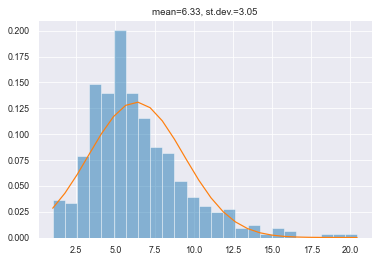

In [222]:
get_hist_with_norm_dist(calc_average_utt_len(hh_dialog))

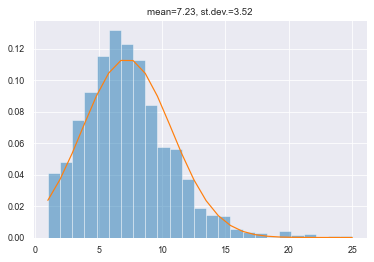

In [223]:
get_hist_with_norm_dist(calc_average_utt_len(hb_dialog))

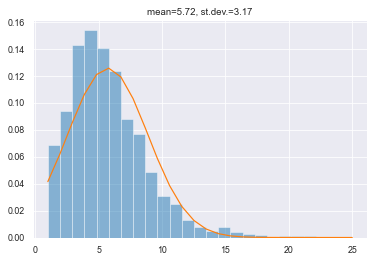

In [224]:
get_hist_with_norm_dist(calc_average_utt_len(hb_dialog_humans))

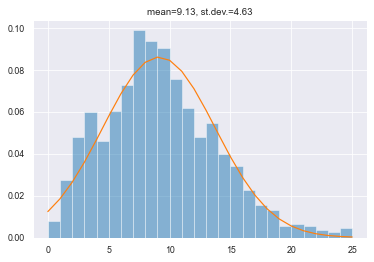

In [225]:
get_hist_with_norm_dist(calc_average_utt_len(hb_dialog_bots))

### NP count

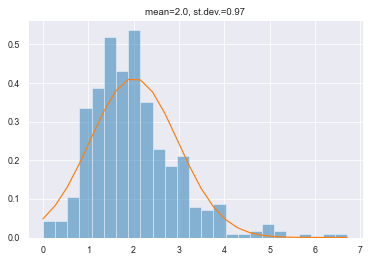

In [226]:
get_hist_with_norm_dist(calc_average_np_len(hh_dialog))

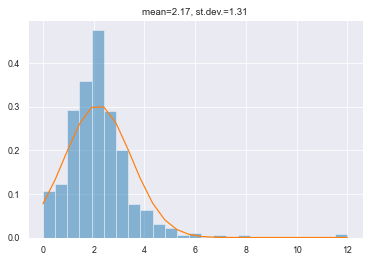

In [227]:
get_hist_with_norm_dist(calc_average_np_len(hb_dialog))

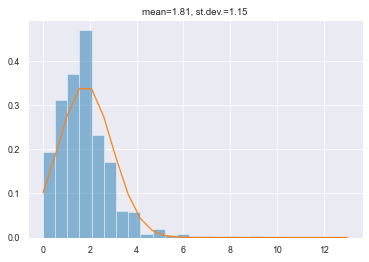

In [228]:
get_hist_with_norm_dist(calc_average_np_len(hb_dialog_humans))

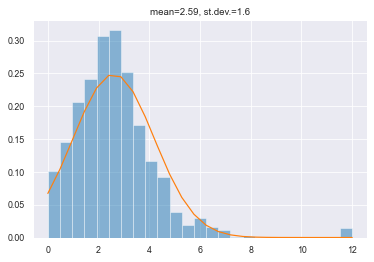

In [229]:
get_hist_with_norm_dist(calc_average_np_len(hb_dialog_bots))

### NLLs

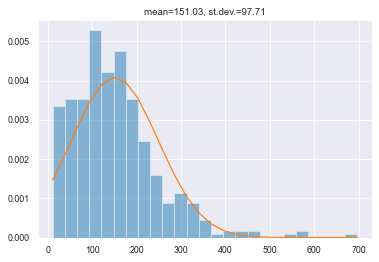

In [230]:
get_hist_with_norm_dist(calc_average_nll(hh_dialog))

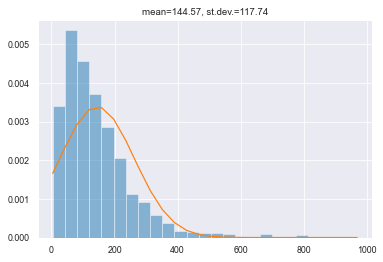

In [231]:
get_hist_with_norm_dist(calc_average_nll(hb_dialog))

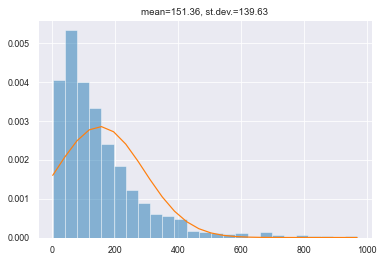

In [232]:
get_hist_with_norm_dist(calc_average_nll(hb_dialog_humans))

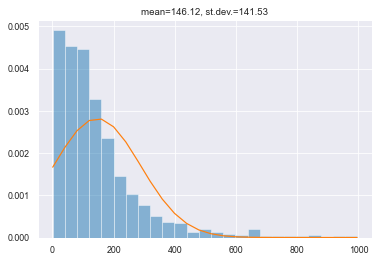

In [233]:
get_hist_with_norm_dist(calc_average_nll(hb_dialog_bots))

## Correlations

In [234]:
import pandas as pd

In [235]:
def construct_df(dataset, consider_bots=False):
    rows_list = []
    for d in dataset:
        row = {}
        user_1 = d['users'][0]
        user_2 = d['users'][1]
        if consider_bots:
            # Guarantee that user 1 is always human
            if user_1['userType'] == 'Bot':
                user_bot = user_1
                user_1 = user_2
                user_2 = user_bot

        eval_user_1 = [ev for ev in d['evaluation'] if ev['userId'] == user_1['id']][0]
        thread_user_1 = [th for th in d['thread'] if th['userId'] == user_1['id']]
        if thread_user_1:
            utt_user_1 = [th['UTT_LEN'] for th in thread_user_1]
            np_user_1 = [th['NP_LEN'] for th in thread_user_1]
            try:
                nll_user_1 = [th['NLL'] for th in thread_user_1]
            except KeyError:
                nll_user_1 = [0]
            if not consider_bots:
                row['breadth_user_1'] = eval_user_1['breadth']
                row['quality_user_1'] = eval_user_1['quality']
                row['engagement_user_1'] = eval_user_1['engagement']
            row['utt_user_1'] = sum(utt_user_1) / len(utt_user_1)
            row['np_user_1'] = sum(np_user_1) / len(np_user_1)
            row['nll_user_1'] = sum(nll_user_1) / len(nll_user_1)
            if row['nll_user_1'] >= NLL_LIMIT:
                row['nll_user_1'] = NLL_LIMIT

        eval_user_2 = [ev for ev in d['evaluation'] if ev['userId'] == user_2['id']][0]
        thread_user_2 = [th for th in d['thread'] if th['userId'] == user_2['id']]
        if thread_user_2:
            utt_user_2 = [th['UTT_LEN'] for th in thread_user_2]
            np_user_2 = [th['NP_LEN'] for th in thread_user_2]
            try:
                nll_user_2 = [th['NLL'] for th in thread_user_2]
            except KeyError:
                nll_user_2 = [0]
            row['breadth_user_2'] = eval_user_2['breadth']
            row['quality_user_2'] = eval_user_2['quality']
            row['engagement_user_2'] = eval_user_2['engagement']
            row['utt_user_2'] = sum(utt_user_2) / len(utt_user_2)
            row['np_user_2'] = sum(np_user_2) / len(np_user_2)
            row['nll_user_2'] = sum(nll_user_2) / len(nll_user_2)
            if row['nll_user_2'] >= NLL_LIMIT:
                row['nll_user_2'] = NLL_LIMIT

        rows_list.append(row)
    return rows_list

In [147]:
df_hh = pd.DataFrame(data=construct_df(hh_dialog), columns=[
    'breadth_user_1',
    'quality_user_1',
    'engagement_user_1',
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

In [148]:
df_hb = pd.DataFrame(data=construct_df(hb_dialog), columns=[
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

### Graphs

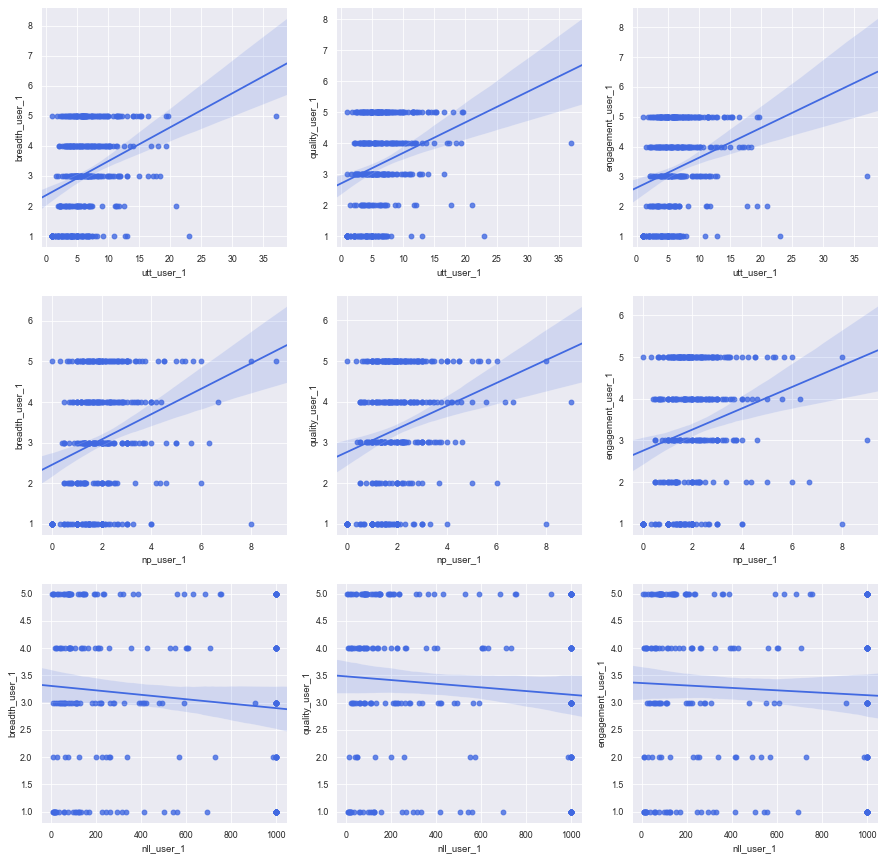

In [166]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, in_metric in enumerate(['utt_user_1', 'np_user_1', 'nll_user_1']):
    for j, q_metric in enumerate(['breadth_user_1', 'quality_user_1', 'engagement_user_1']):
        # sns.jointplot(x=in_metric, y=q_metric, data=df_hh,
        #               kind="reg", truncate=False,
        #               color="royalblue", height=7, ax=axes[i])
        sns.regplot(x=in_metric, y=q_metric, data=df_hh,
                    truncate=False, color="royalblue", ax=axes[i][j])

plt.show()

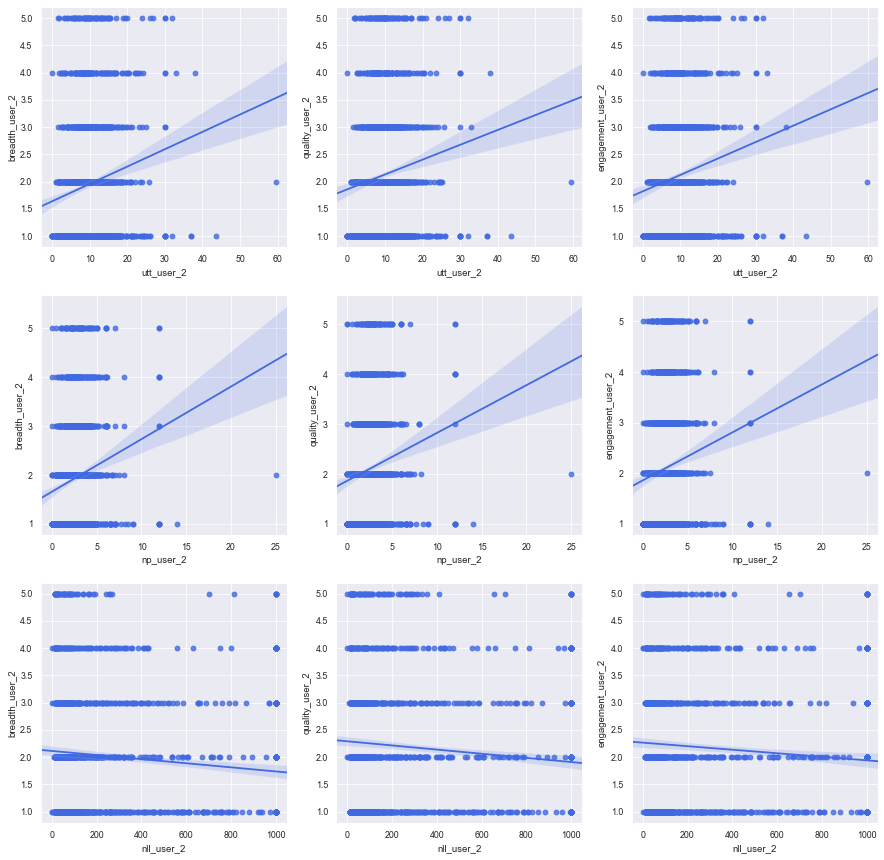

In [168]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, in_metric in enumerate(['utt_user_2', 'np_user_2', 'nll_user_2']):
    for j, q_metric in enumerate(['breadth_user_2', 'quality_user_2', 'engagement_user_2']):
        # sns.jointplot(x=in_metric, y=q_metric, data=df_hb,
        #               kind="reg", truncate=False,
        #               color="royalblue", height=7)
        sns.regplot(x=in_metric, y=q_metric, data=df_hb,
                    truncate=False, color="royalblue", ax=axes[i][j])

plt.show()

### Corr coefficients and P-values

In [169]:
def calculate_pvalues(df, method='pearson'):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            elif method == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            elif method == 'kendall':
                pvalues[r][c] = round(kendalltau(df[r], df[c])[1], 4)
    return pvalues

#### Spearman

##### Humans

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  utt\\_user\\_1 &  np\\_user\\_1 &  nll\\_user\\_1 \\\\\n\\midrule\nbreadth\\_user\\_1    &        0.35 &       0.28 &       -0.08 \\\\\nquality\\_user\\_1    &        0.30 &       0.25 &       -0.05 \\\\\nengagement\\_user\\_1 &        0.32 &       0.23 &       -0.02 \\\\\n\\bottomrule\n\\end{tabular}\n'

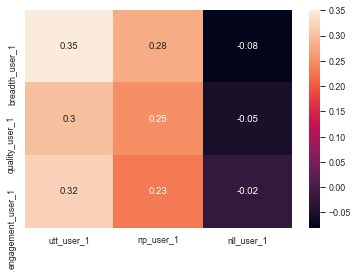

In [172]:
hh_init_qualit = round(df_hh.corr('spearman')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']], 2)
sns.heatmap(hh_init_qualit, annot=True)
hh_init_qualit.to_latex()

In [115]:
calculate_pvalues(df_hh)[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]

,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0002,0.0137
quality_user_1,0.0003,0.0019,0.0158
engagement_user_1,0.0003,0.0083,0.0261


##### Bots

<AxesSubplot:>

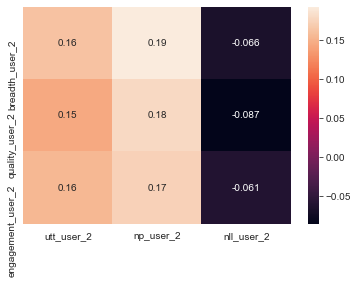

In [118]:
hb_init_qualit = df_hb.corr('spearman')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [119]:
calculate_pvalues(df_hb)[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0139,0.0014,0.0054
quality_user_2,0.0782,0.0203,0.0007
engagement_user_2,0.0974,0.0999,0.0543


#### Pearson

##### Humans

<AxesSubplot:>

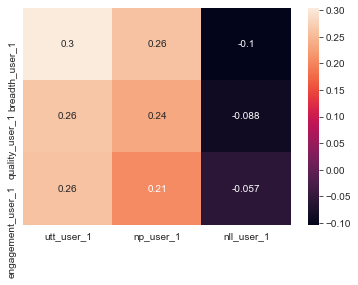

In [107]:
sns.heatmap(df_hh.corr('pearson')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']], annot=True)

In [116]:
calculate_pvalues(df_hh, 'pearson')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]


,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0002,0.0137
quality_user_1,0.0003,0.0019,0.0158
engagement_user_1,0.0003,0.0083,0.0261


##### Bots

<AxesSubplot:>

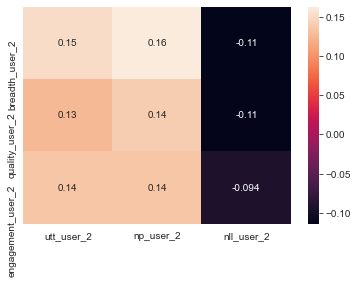

In [125]:
hb_init_qualit = df_hb.corr('pearson')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [123]:
calculate_pvalues(df_hb, 'pearson')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0139,0.0014,0.0054
quality_user_2,0.0782,0.0203,0.0007
engagement_user_2,0.0974,0.0999,0.0543


#### Kendall

##### Humans

<AxesSubplot:>

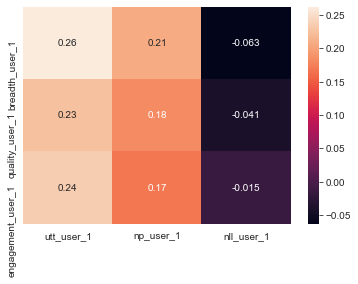

In [108]:
sns.heatmap(df_hh.corr('kendall')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']], annot=True)

In [117]:
calculate_pvalues(df_hh, 'kendall')[['utt_user_1', 'np_user_1', 'nll_user_1']].loc[['breadth_user_1', 'quality_user_1', 'engagement_user_1']]


,utt_user_1,np_user_1,nll_user_1
breadth_user_1,0.0,0.0,0.0513
quality_user_1,0.0,0.0002,0.0966
engagement_user_1,0.0,0.0003,0.2005


##### Bots

<AxesSubplot:>

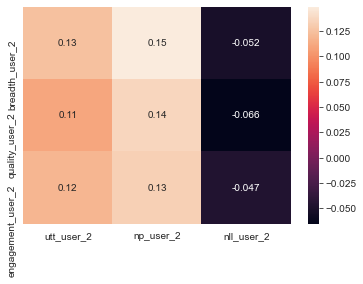

In [126]:
hb_init_qualit = df_hb.corr('kendall')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]
sns.heatmap(hb_init_qualit, annot=True)

In [127]:
calculate_pvalues(df_hb, 'kendall')[['utt_user_2', 'np_user_2', 'nll_user_2']].loc[['breadth_user_2', 'quality_user_2', 'engagement_user_2']]

,utt_user_2,np_user_2,nll_user_2
breadth_user_2,0.0186,0.0008,0.475
quality_user_2,0.0481,0.0041,0.0244
engagement_user_2,0.0429,0.0375,0.5866


## Human quality estimations vs human initiative

In [241]:
def get_human_data(dataset):
    rows_list = []
    for d in dataset:
        user_1 = d['users'][0]
        user_2 = d['users'][1]

        eval_user_1 = [ev for ev in d['evaluation'] if ev['userId'] == user_1['id']][0]
        thread_user_1 = [th for th in d['thread'] if th['userId'] == user_1['id']]
        if thread_user_1:
            row = {}
            utt_user_1 = [th['UTT_LEN'] for th in thread_user_1]
            np_user_1 = [th['NP_LEN'] for th in thread_user_1]
            try:
                nll_user_1 = [th['NLL'] for th in thread_user_1]
            except KeyError:
                nll_user_1 = [0]
            row['breadth'] = eval_user_1['breadth']
            row['quality'] = eval_user_1['quality']
            row['engagement'] = eval_user_1['engagement']
            row['utt'] = sum(utt_user_1) / len(utt_user_1)
            row['np'] = sum(np_user_1) / len(np_user_1)
            row['nll'] = sum(nll_user_1) / len(nll_user_1)
            if row['utt'] >= UTT_LEN_LIMIT:
                row['utt'] = UTT_LEN_LIMIT
            if row['np'] >= NP_LEN_LIMIT:
                row['np'] = NP_LEN_LIMIT
            if row['nll'] >= NLL_LIMIT:
                row['nll'] = NLL_LIMIT
            rows_list.append(row)

        eval_user_2 = [ev for ev in d['evaluation'] if ev['userId'] == user_2['id']][0]
        thread_user_2 = [th for th in d['thread'] if th['userId'] == user_2['id']]
        if thread_user_2:
            row = {}
            utt_user_2 = [th['UTT_LEN'] for th in thread_user_2]
            np_user_2 = [th['NP_LEN'] for th in thread_user_2]
            try:
                nll_user_2 = [th['NLL'] for th in thread_user_2]
            except KeyError:
                nll_user_2 = [0]
            row['breadth'] = eval_user_2['breadth']
            row['quality'] = eval_user_2['quality']
            row['engagement'] = eval_user_2['engagement']
            row['utt'] = sum(utt_user_2) / len(utt_user_2)
            row['np'] = sum(np_user_2) / len(np_user_2)
            row['nll'] = sum(nll_user_2) / len(nll_user_2)
            if row['utt'] >= UTT_LEN_LIMIT:
                row['utt'] = UTT_LEN_LIMIT
            if row['np'] >= NP_LEN_LIMIT:
                row['np'] = NP_LEN_LIMIT
            if row['nll'] >= NLL_LIMIT:
                row['nll'] = NLL_LIMIT
            rows_list.append(row)
    return rows_list

In [242]:
human_data = get_human_data(hh_dialog)
# human_data.extend(get_human_data(filter_users(hb_dialog, "Human")))
df_human = pd.DataFrame(human_data)

In [251]:
human_corrs = df_human.corr()[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
human_corrs

,breadth,quality,engagement
utt,0.247836,0.229420,0.228595
np,0.221315,0.196955,0.199899
nll,-0.048525,-0.071920,-0.048533


In [256]:
round(human_corrs, 2).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  breadth &  quality &  engagement \\\\\n\\midrule\nutt &     0.25 &     0.23 &        0.23 \\\\\nnp  &     0.22 &     0.20 &        0.20 \\\\\nnll &    -0.05 &    -0.07 &       -0.05 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [264]:
human_pvalues = calculate_pvalues(df_human)[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
human_pvalues

,breadth,quality,engagement
utt,0.0,0.0,0.0
np,0.0,0.0002,0.0002
nll,0.3065,0.1294,0.3065


In [268]:
human_pvalues.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & breadth & quality & engagement \\\\\n\\midrule\nutt &     0.0 &     0.0 &        0.0 \\\\\nnp  &     0.0 &  0.0002 &     0.0002 \\\\\nnll &  0.3065 &  0.1294 &     0.3065 \\\\\n\\bottomrule\n\\end{tabular}\n'

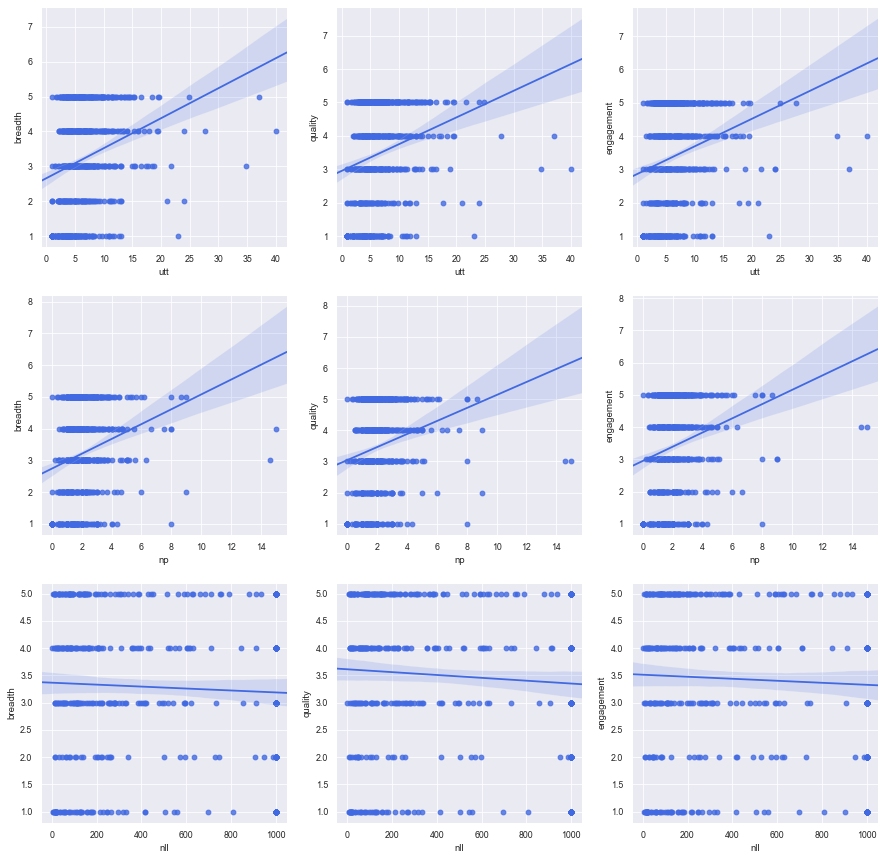

In [269]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, in_metric in enumerate(['utt', 'np', 'nll']):
    for j, q_metric in enumerate(['breadth', 'quality', 'engagement']):
        # sns.jointplot(x=in_metric, y=q_metric, data=df_hh,
        #               kind="reg", truncate=False,
        #               color="royalblue", height=7, ax=axes[i])
        sns.regplot(x=in_metric, y=q_metric, data=df_human,
                    truncate=False, color="royalblue", ax=axes[i][j])

plt.show()

In [270]:
df_bot = pd.DataFrame(get_human_data(filter_users(hb_dialog, "Bot")))
print(df_bot)

      breadth  quality  engagement        utt        np          nll
0           5        1           5   8.400000  2.400000          NaN
1           3        3           4   9.700000  3.400000   376.575556
2           3        1           1  11.333333  3.166667   108.762469
3           3        2           3   9.888889  3.666667          NaN
4           5        4           5   7.000000  1.555556          NaN
...       ...      ...         ...        ...       ...          ...
1764        1        1           2   7.333333  1.333333   824.645725
1765        4        3           4  15.166667  3.333333          NaN
1766        1        1           1   7.333333  3.333333  1000.000000
1767        1        1           1  15.750000  4.250000    13.217704
1768        1        1           1  18.000000  6.500000    26.826183

[1769 rows x 6 columns]


In [273]:
bot_corrs = df_bot.corr()[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
bot_corrs

,breadth,quality,engagement
utt,0.154718,0.128930,0.137985
np,0.168078,0.146010,0.139919
nll,-0.114314,-0.112993,-0.093626


In [274]:
round(bot_corrs, 2).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  breadth &  quality &  engagement \\\\\n\\midrule\nutt &     0.15 &     0.13 &        0.14 \\\\\nnp  &     0.17 &     0.15 &        0.14 \\\\\nnll &    -0.11 &    -0.11 &       -0.09 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [275]:
bot_pvalues = calculate_pvalues(df_bot)[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
bot_pvalues

,breadth,quality,engagement
utt,0.0,0.0074,0.0014
np,0.0,0.0005,0.0012
nll,0.0,0.0,0.0006


In [276]:
bot_pvalues.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & breadth & quality & engagement \\\\\n\\midrule\nutt &     0.0 &  0.0074 &     0.0014 \\\\\nnp  &     0.0 &  0.0005 &     0.0012 \\\\\nnll &     0.0 &     0.0 &     0.0006 \\\\\n\\bottomrule\n\\end{tabular}\n'

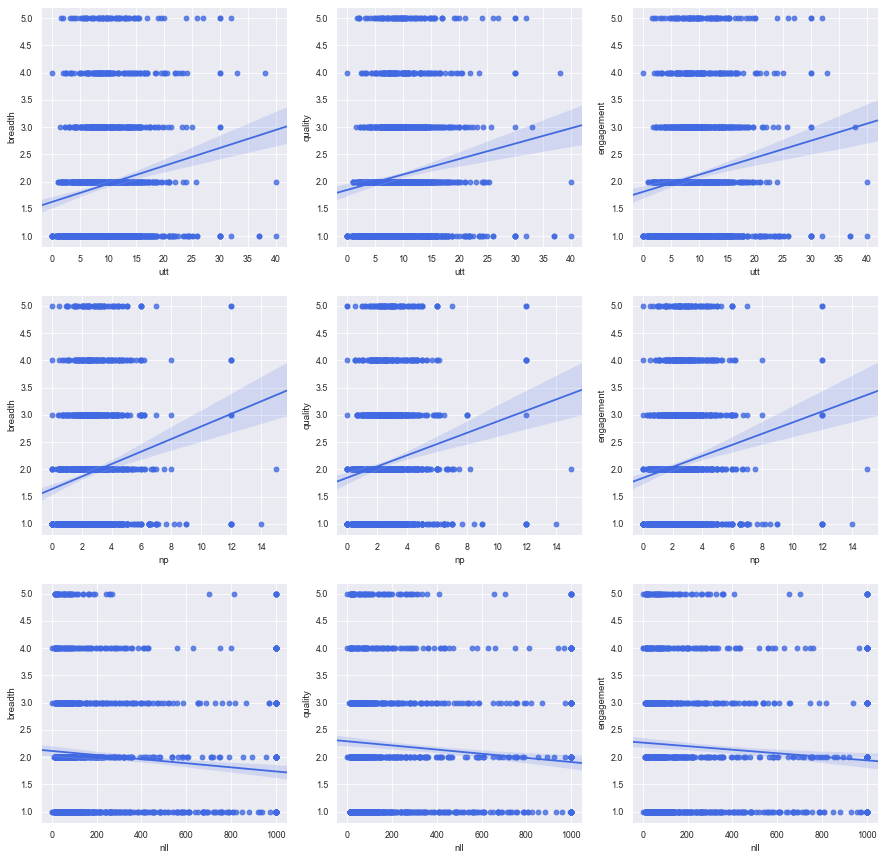

In [249]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, in_metric in enumerate(['utt', 'np', 'nll']):
    for j, q_metric in enumerate(['breadth', 'quality', 'engagement']):
        # sns.jointplot(x=in_metric, y=q_metric, data=df_hh,
        #               kind="reg", truncate=False,
        #               color="royalblue", height=7, ax=axes[i])
        sns.regplot(x=in_metric, y=q_metric, data=df_bot,
                    truncate=False, color="royalblue", ax=axes[i][j])

plt.show()

In [284]:
def get_human_data_in_bot_conversation(dataset):
    rows_list = []
    for d in dataset:
        row = {}
        user_1 = d['users'][0]
        user_2 = d['users'][1]
        # Guarantee that user 1 is always human
        if user_1['userType'] == 'Bot':
            user_bot = user_1
            user_1 = user_2
            user_2 = user_bot

        thread_user_1 = [th for th in d['thread'] if th['userId'] == user_1['id']]
        if thread_user_1:
            utt_user_1 = [th['UTT_LEN'] for th in thread_user_1]
            np_user_1 = [th['NP_LEN'] for th in thread_user_1]
            try:
                nll_user_1 = [th['NLL'] for th in thread_user_1]
            except KeyError:
                nll_user_1 = [0]
            row['utt'] = sum(utt_user_1) / len(utt_user_1)
            row['np'] = sum(np_user_1) / len(np_user_1)
            row['nll'] = sum(nll_user_1) / len(nll_user_1)
            if row['utt'] >= UTT_LEN_LIMIT:
                row['utt'] = UTT_LEN_LIMIT
            if row['np'] >= NP_LEN_LIMIT:
                row['np'] = NP_LEN_LIMIT
            if row['nll'] >= NLL_LIMIT:
                row['nll'] = NLL_LIMIT

        eval_user_2 = [ev for ev in d['evaluation'] if ev['userId'] == user_2['id']][0]
        thread_user_2 = [th for th in d['thread'] if th['userId'] == user_2['id']]
        if thread_user_2:
            row['breadth'] = eval_user_2['breadth']
            row['quality'] = eval_user_2['quality']
            row['engagement'] = eval_user_2['engagement']
        rows_list.append(row)
    return rows_list

In [287]:
df_human_in_hb = pd.DataFrame(get_human_data_in_bot_conversation(hb_dialog))
print(df_human_in_hb)


       utt        np         nll  breadth  quality  engagement
0     3.00  1.000000         NaN      5.0      1.0         5.0
1     1.50  0.666667         NaN      3.0      3.0         4.0
2      NaN       NaN         NaN      NaN      NaN         NaN
3      NaN       NaN         NaN      NaN      NaN         NaN
4     8.00  2.000000   45.420217      NaN      NaN         NaN
...    ...       ...         ...      ...      ...         ...
2332  8.00  2.750000   69.508949      4.0      3.0         4.0
2333  2.25  1.000000         NaN      1.0      1.0         1.0
2334  4.00  1.333333   43.848566      1.0      1.0         1.0
2335  7.00  2.000000  145.152459      1.0      1.0         1.0
2336  1.00  0.000000         NaN      NaN      NaN         NaN

[2337 rows x 6 columns]


In [288]:
human_in_hb_corrs = df_human_in_hb.corr()[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
human_in_hb_corrs

,breadth,quality,engagement
utt,0.036606,0.091695,0.093487
np,0.028861,0.073480,0.065583
nll,0.052543,0.012373,0.002235


In [289]:
round(human_in_hb_corrs, 2).to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  breadth &  quality &  engagement \\\\\n\\midrule\nutt &     0.04 &     0.09 &        0.09 \\\\\nnp  &     0.03 &     0.07 &        0.07 \\\\\nnll &     0.05 &     0.01 &        0.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [291]:
human_in_hb_pvalues = calculate_pvalues(df_human_in_hb)[['breadth', 'quality', 'engagement']].loc[['utt', 'np', 'nll']]
human_in_hb_pvalues

,breadth,quality,engagement
utt,0.4332,0.0085,0.0072
np,0.8704,0.1553,0.2462
nll,0.0921,0.6918,0.9429


In [292]:
human_in_hb_pvalues.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & breadth & quality & engagement \\\\\n\\midrule\nutt &  0.4332 &  0.0085 &     0.0072 \\\\\nnp  &  0.8704 &  0.1553 &     0.2462 \\\\\nnll &  0.0921 &  0.6918 &     0.9429 \\\\\n\\bottomrule\n\\end{tabular}\n'

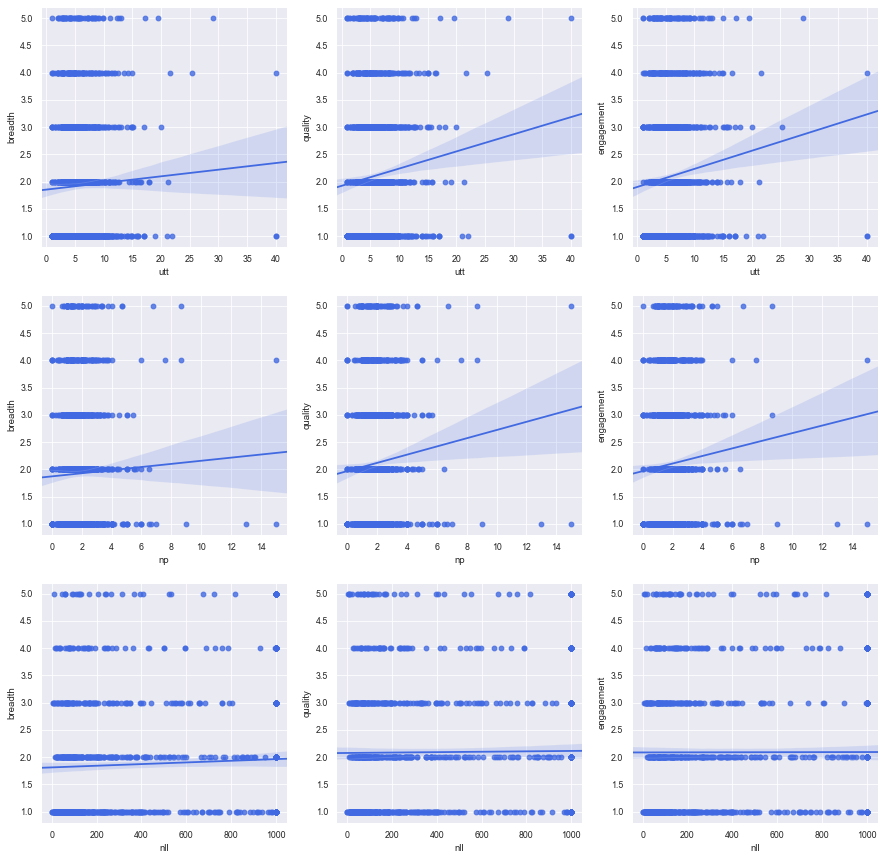

In [293]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, in_metric in enumerate(['utt', 'np', 'nll']):
    for j, q_metric in enumerate(['breadth', 'quality', 'engagement']):
        # sns.jointplot(x=in_metric, y=q_metric, data=df_hh,
        #               kind="reg", truncate=False,
        #               color="royalblue", height=7, ax=axes[i])
        sns.regplot(x=in_metric, y=q_metric, data=df_human_in_hb,
                    truncate=False, color="royalblue", ax=axes[i][j])

plt.show()